In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('store-sales-time-series-forecasting/train.csv')
stores = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
holidays_events = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('store-sales-time-series-forecasting/oil.csv')

### **Data Processing**

In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
# Merge df with stores data
df = pd.merge(df, stores, how='left', on='store_nbr').drop('id', axis=1)

In [6]:
# Selecting only unique national holiday and event dates
holidays_events = holidays_events.query('type != "Work Day" and transferred == False and locale_name == "Ecuador"').query('~date.duplicated()')[['date', 'type', 'description']]

# Removing 'Traslado' (Transferred) from affected descriptions
holidays_events.description = holidays_events.description.apply(lambda x: x.replace('Traslado', ''))

# Convert date features to a datetime object
holidays_events.date = pd.to_datetime(holidays_events.date)
df.date = pd.to_datetime(df.date)

# Converting relevant types into Holiday value
holidays_events.type = holidays_events.type.apply(lambda x: 'Holiday' if x in ['Holiday', 'Additional', 'Transfer', 'Bridge'] else 'Event')

# Rename column to avoid clashing with the type feature that is already in the main dataframe
holidays_events = holidays_events.rename(columns={'type': 'h_e_type'})

# Merge and fill missing values on non-holiday or event dates
df = df.merge(holidays_events, on='date', how='left').fillna('None')
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,h_e_type,description
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano


In [7]:
# Oil commodity not traded on weekends and some holidays, which causes the dates to be non-equidistant
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
# Create a dataframe with equidistant dates
all_dates = pd.DataFrame({'date': pd.date_range('2013-01-01', '2017-08-31')})

# Convert date feature to datetime object
oil.date = oil.date.astype('datetime64[ns]')

# Merge both dataframes
oil_full = all_dates.merge(oil, how='left', on='date')

# Fill in the new missing values
oil_full.dcoilwtico = oil_full.dcoilwtico.interpolate(method='linear').fillna(oil.dcoilwtico[:5].mean())

In [9]:
df = df.merge(oil_full, how='left', on='date')
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,h_e_type,description,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075


In [10]:
# Reduce memory usage
df = df.astype({'store_nbr': 'int8', 
                  'family': 'category', 
                  'sales': 'float32', 
                  'onpromotion': 'int16', 
                  'city': 'category', 
                  'state': 'category', 
                  'type': 'category', 
                  'h_e_type': 'category', 
                  'description': 'category',
                  'cluster': 'int8', 
                #   'dcoilwtico': 'float16'
                  })

In [11]:
print(df.info(), "\n", df.isna().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int8          
 2   family       category      
 3   sales        float32       
 4   onpromotion  int16         
 5   city         category      
 6   state        category      
 7   type         category      
 8   cluster      int8          
 9   h_e_type     category      
 10  description  category      
 11  dcoilwtico   float64       
dtypes: category(6), datetime64[ns](1), float32(1), float64(1), int16(1), int8(2)
memory usage: 85.9 MB
None 
 date           False
store_nbr      False
family         False
sales          False
onpromotion    False
city           False
state          False
type           False
cluster        False
h_e_type       False
description    False
dcoilwtico     False
dtype: bool


### **Data Exploration**

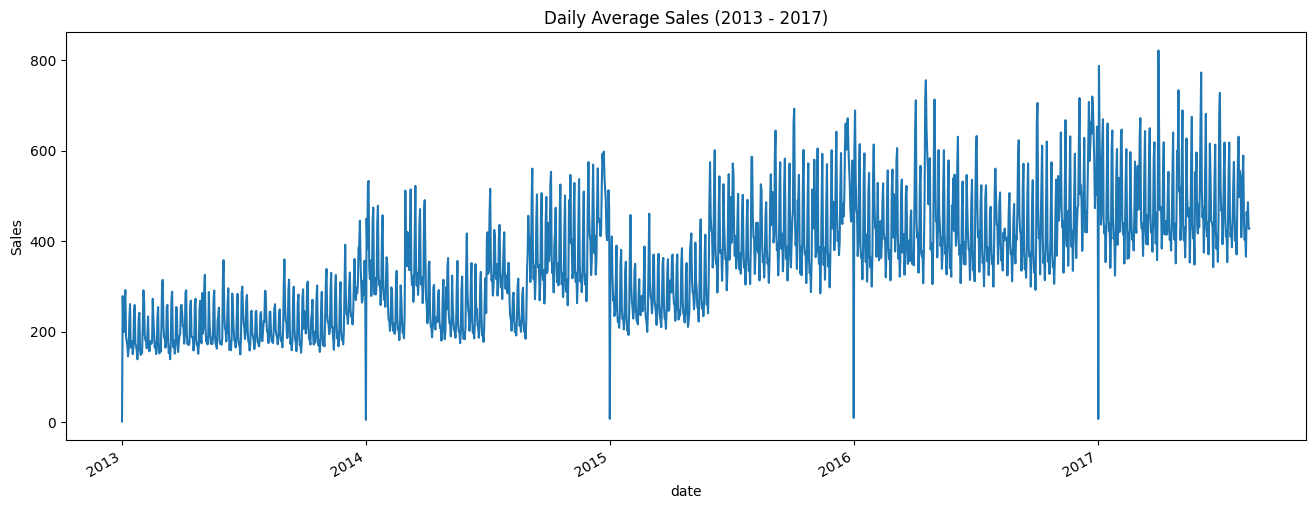

In [12]:
# Sales overview
df.groupby('date').sales.mean().plot(ylabel='Sales', title='Daily Average Sales (2013 - 2017)', figsize=(16, 6));

* The outliers near 0 happened on New Year's Day, which was most probably because stores were closed on that day.
* Strong fluctuations in sales from day to day.
* Relatively linear growth trend.

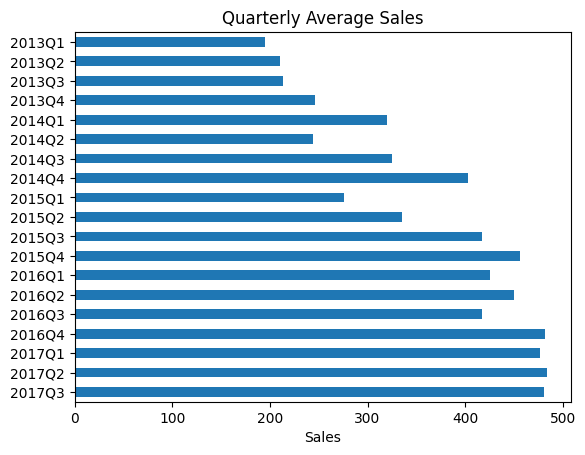

In [13]:
# Quarterly sales over the years
df.groupby(pd.Grouper(key='date', freq='BQ')).sales.mean().to_period("Q").sort_index(ascending=False).plot(kind='barh', ylabel='', xlabel='Sales', title='Quarterly Average Sales');

*   Sales generally increased quarter-over-quarter with Q4 being the top performing quarter.

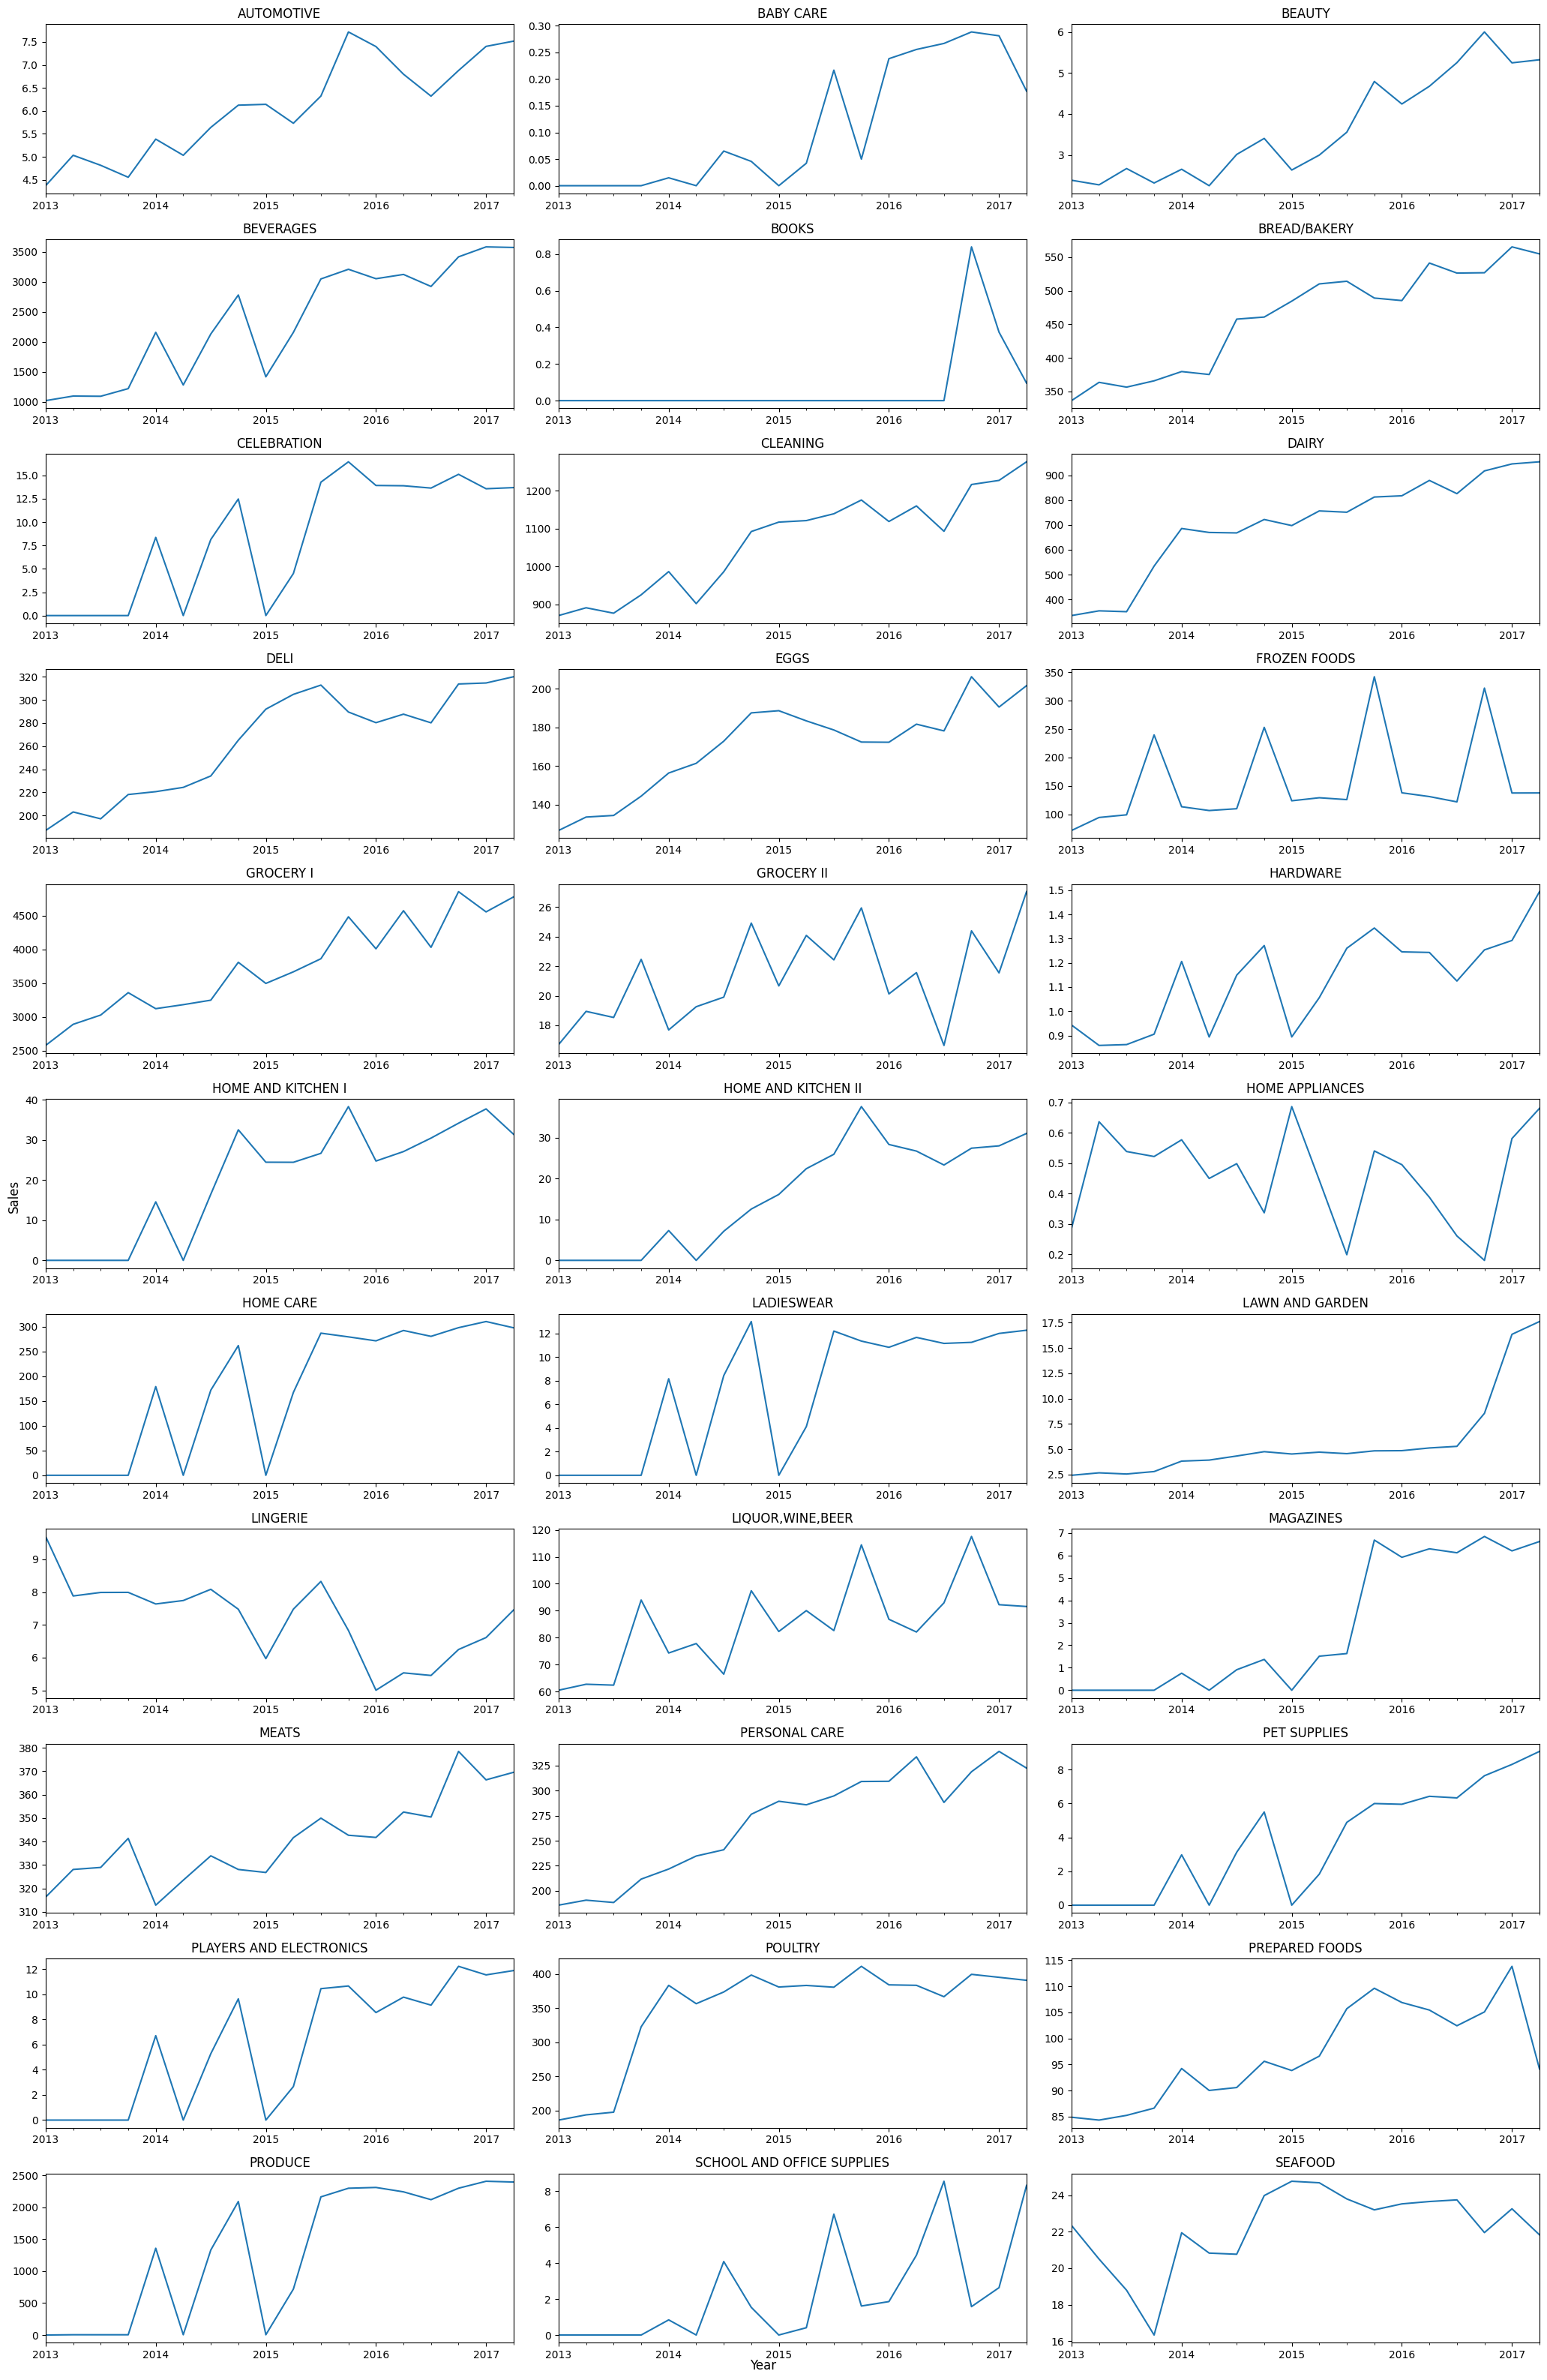

In [14]:
# Quarterly sales by product family, excluding the incomplete 2017Q3 data
temp_df = df.query('date < "2017/07"')
temp_df.family.nunique() # 33 unique product families
family_names = temp_df.family.unique() 
fig = plt.figure(figsize=(21, 32))

for i, family in enumerate(family_names):
  ax = fig.add_subplot(11, 3, i+1)
  temp_df.query('family == @family').groupby(pd.Grouper(key='date', freq='BQ')).sales.mean().plot(xlabel='')
  plt.title(family)

fig.supxlabel('Year')
fig.supylabel('Sales')
plt.tight_layout()

*   Many product families such as produce and pet supplies saw 0 sales in some quarters, typically in 2014Q1 and 2014Q4.
*   Books product family launched only during 2016Q4.
*   All except lingerie and home appliances saw a general growth trend across the years.



In [15]:
# Investigate product families with 0 sales
quarterly_sales = df.set_index('date').to_period('Q').groupby(['date', 'family']).sales.mean()
quarterly_sales[quarterly_sales == 0].reset_index().date.value_counts().sort_index()

date
2013Q1    11
2013Q2    11
2013Q3    11
2013Q4    11
2014Q1     1
2014Q2    11
2014Q3     1
2014Q4     1
2015Q1     9
2015Q2     1
2015Q3     1
2015Q4     1
2016Q1     1
2016Q2     1
2016Q3     1
Freq: Q-DEC, Name: count, dtype: int64

In [16]:
quarters_0_sales = ['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q2', '2015Q1']
quarterly_sales[quarterly_sales == 0].unstack().loc[quarters_0_sales]

family,BABY CARE,BOOKS,CELEBRATION,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME CARE,LADIESWEAR,MAGAZINES,PET SUPPLIES,PLAYERS AND ELECTRONICS,SCHOOL AND OFFICE SUPPLIES
date,,,,,,,,,,,
2013Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013Q4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015Q1,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


*   The quarters with a high number of product families with 0 sales can be explained by those product families not being on sale in those periods.
*   For the quarters with 1 product family with 0 sales, it was because of the books family not being launched yet.

In [17]:
from pandas.tseries.offsets import DateOffset

In [18]:
df.query('date <= "2017/08" and date.dt.day == 15').date.unique()

<DatetimeArray>
['2013-01-15 00:00:00', '2013-02-15 00:00:00', '2013-03-15 00:00:00',
 '2013-04-15 00:00:00', '2013-05-15 00:00:00', '2013-06-15 00:00:00',
 '2013-07-15 00:00:00', '2013-08-15 00:00:00', '2013-09-15 00:00:00',
 '2013-10-15 00:00:00', '2013-11-15 00:00:00', '2013-12-15 00:00:00',
 '2014-01-15 00:00:00', '2014-02-15 00:00:00', '2014-03-15 00:00:00',
 '2014-04-15 00:00:00', '2014-05-15 00:00:00', '2014-06-15 00:00:00',
 '2014-07-15 00:00:00', '2014-08-15 00:00:00', '2014-09-15 00:00:00',
 '2014-10-15 00:00:00', '2014-11-15 00:00:00', '2014-12-15 00:00:00',
 '2015-01-15 00:00:00', '2015-02-15 00:00:00', '2015-03-15 00:00:00',
 '2015-04-15 00:00:00', '2015-05-15 00:00:00', '2015-06-15 00:00:00',
 '2015-07-15 00:00:00', '2015-08-15 00:00:00', '2015-09-15 00:00:00',
 '2015-10-15 00:00:00', '2015-11-15 00:00:00', '2015-12-15 00:00:00',
 '2016-01-15 00:00:00', '2016-02-15 00:00:00', '2016-03-15 00:00:00',
 '2016-04-15 00:00:00', '2016-05-15 00:00:00', '2016-06-15 00:00:00',
 '20

In [19]:
# As per the metadata, wages in Ecuador's public sector are paid every two weeks: on the 15th and on the last day of the month, which could affect sales
# I want to investigate its effect, specifically by looking at sales from these days + 6 days compared with the rest of the days in the month 
from pandas.tseries.offsets import MonthEnd
monthend_list = ((df.query('date < "2017/08"').date.drop_duplicates() + MonthEnd())).unique() # Getting all the unique months and their respective end month dates in the data
monthend_filter = []
for month in monthend_list:
  monthend_filter.extend(pd.date_range(month, periods=7).strftime("%Y/%m/%d"))

midmonth_list = df.query('date < "2017/09" and date.dt.day == 15').date.unique()
midmonth_filter = []
for month in midmonth_list:
  midmonth_filter.extend(pd.date_range(month, periods=7).strftime("%Y/%m/%d"))

# Check if lists are right
combined_filter = monthend_filter + midmonth_filter
print('Month end + 6 days:', monthend_filter[:7], "\n", '15th of month + 6 days:', midmonth_filter[:7])

Month end + 6 days: ['2013/01/31', '2013/02/01', '2013/02/02', '2013/02/03', '2013/02/04', '2013/02/05', '2013/02/06'] 
 15th of month + 6 days: ['2013/01/15', '2013/01/16', '2013/01/17', '2013/01/18', '2013/01/19', '2013/01/20', '2013/01/21']


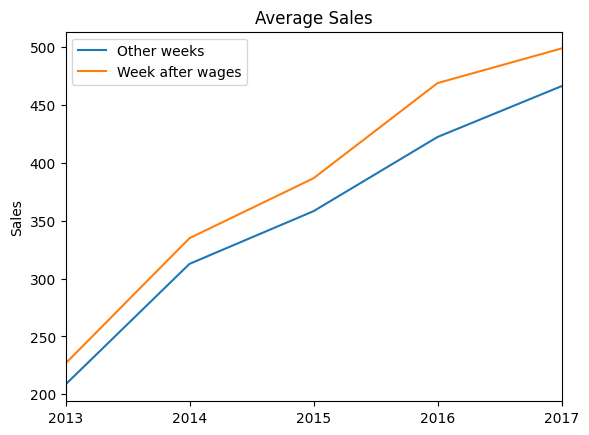

In [20]:
# Visualising the average difference in sales between wage weeks and non-wage weeks
df.query('date < "2017/08" and date not in @combined_filter').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
df.query('date in @combined_filter').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
plt.legend(['Other weeks', 'Week after wages'])
plt.xlabel('')
plt.ylabel('Sales')
plt.title('Average Sales');

* Uplift in average sales the week following public sector wages being paid out.

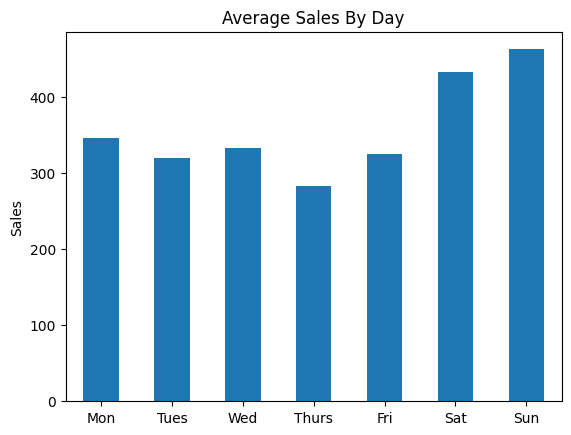

In [21]:
# Check for weekly seasonality
df['dayofweek'] = df.date.dt.dayofweek
df.groupby('dayofweek').sales.mean().plot.bar(xlabel='', ylabel='Sales', title='Average Sales By Day')
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], rotation=0);

* Sales on the weekends were much higher than sales on weekdays.
* Sales on Thursdays were the lowest on average, which suggests that many Ecuadorians have a habit of shopping for their weekly groceries at either the start or end of the week.

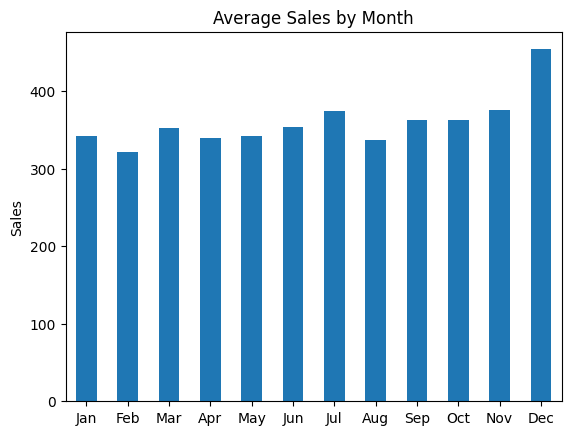

In [22]:
# Check for monthly seasonality
df['month'] = df.date.dt.month
df.groupby('month').sales.mean().plot.bar(title='Average Sales by Month', ylabel='Sales', xlabel='')
plt.gca().set_xticklabels(pd.date_range('2013', periods=12, freq='M').strftime("%b").to_list(), rotation=0);

* Sales experienced a slight increase across the year, with Dec experiencing significantly higher sales.

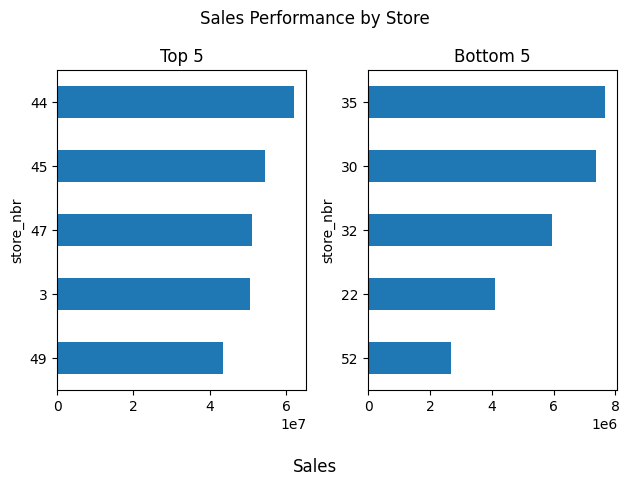

In [23]:
# Find out the sales performance by store
df.store_nbr.nunique() # 54 unique stores

# Top 5 and bottom 5 over the years
fig, ax = plt.subplots(1, 2)
df.groupby('store_nbr').sales.sum().nlargest(5).sort_values().plot.barh(ax=ax[0], title='Top 5')
df.groupby('store_nbr').sales.sum().nsmallest(5).plot.barh(ax=ax[1], title='Bottom 5')
fig.supxlabel('Sales')
plt.suptitle('Sales Performance by Store', fontsize=12)
plt.tight_layout()

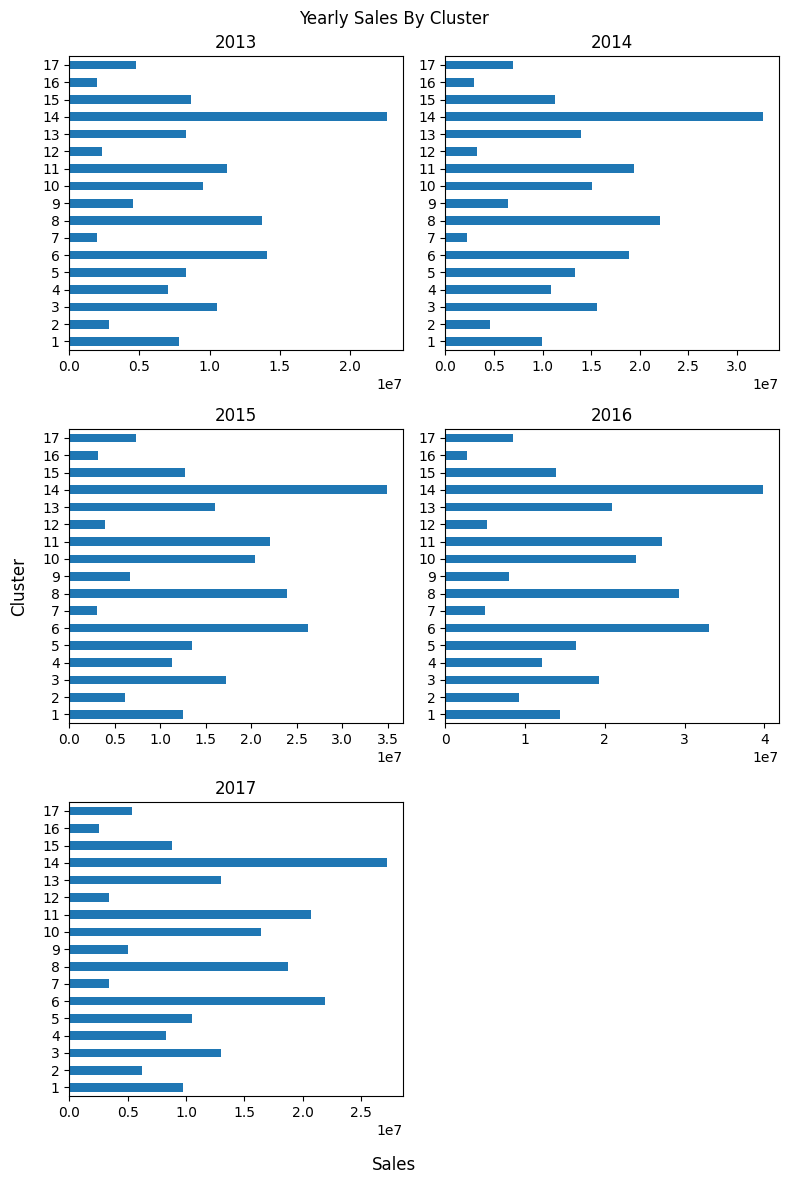

In [24]:
# Yearly sales performance by cluster, where cluster is a grouping of similar stores
cluster_sales = df.set_index('date').to_period('Y').groupby(['date', 'cluster']).sales.sum()

fig = plt.figure(figsize=(8, 12))
years = ['2013', '2014', '2015', '2016', '2017']

for i, year in enumerate(years):
  fig.add_subplot(3, 2, i+1)
  cluster_sales.xs(year).plot.barh(title=f'{year}', ylabel='')

fig.suptitle('Yearly Sales By Cluster')
fig.supylabel('Cluster')
fig.supxlabel('Sales')
plt.tight_layout()

*   The sales performance by cluster looks identical year-over-year.
*   Cluster 14's sales performance was heads and shoulders above the rest, followed by a group of close competitors: clusters 11, 8, and 6.
*   Clusters 16, 12, and 7 were the worst performers.







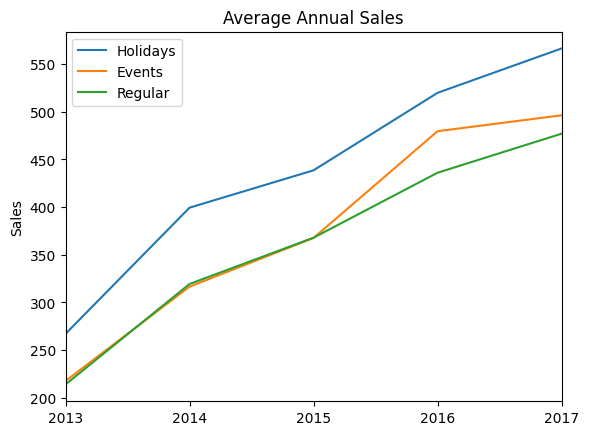

In [25]:
# Investigate the relationship between holidays, events, and sales
df.query('h_e_type in ["Holiday", "Transfer", "Additional", "Bridge"]').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
df.query('h_e_type == "Event"').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()
df.query('h_e_type == "None"').groupby(pd.Grouper(key='date', freq='Y')).sales.mean().plot()

plt.legend(['Holidays', "Events", 'Regular'])
plt.xlabel('')
plt.ylabel('Sales')
plt.title('Average Annual Sales');

* Sales during the holidays were significantly greater than on regular days.
* Sales during events and regular days were the same in 2013 and 2014 but saw a spike in 2015 and slightly higher sales in 2016.

In [26]:
holidays_events.query('h_e_type == "Event"')

,date,h_e_type,description
55,2013-05-12,Event,Dia de la Madre
103,2014-05-11,Event,Dia de la Madre
106,2014-06-12,Event,Inauguracion Mundial de futbol Brasil
107,2014-06-15,Event,Mundial de futbol Brasil: Ecuador-Suiza
108,2014-06-20,Event,Mundial de futbol Brasil: Ecuador-Honduras
113,2014-06-25,Event,Mundial de futbol Brasil: Ecuador-Francia
114,2014-06-28,Event,Mundial de futbol Brasil: Octavos de Final
115,2014-06-29,Event,Mundial de futbol Brasil: Octavos de Final
116,2014-06-30,Event,Mundial de futbol Brasil: Octavos de Final
117,2014-07-01,Event,Mundial de futbol Brasil: Octavos de Final


* The higher average sales on Event days in 2015 was probably because it only had 3 event days, of which 2 were Black Friday and Cyber Monday.
* The 2014 World Cup probably had a negligible effect on sales.
* The 2016 earthquake of magnitude 7.8 in Ecuador had probably elevated sales.

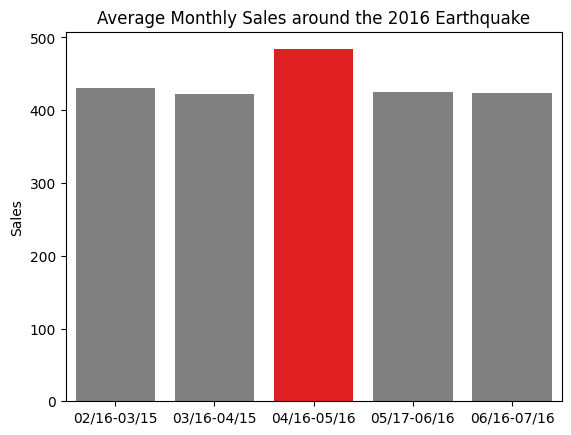

In [28]:
previous_month_1 = pd.date_range('2016-03-16', '2016-04-15')
previous_month_2 = pd.date_range('2016-02-16', '2016-03-15')
following_month_1 = pd.date_range('2016-05-17', '2016-06-16')
following_month_2 = pd.date_range('2016-06-17', '2016-07-16')

eq_df = pd.DataFrame([df.query('date in @previous_month_2').sales.mean(),
                    df.query('date in @previous_month_1').sales.mean(),
                    df.query('description.str.contains("Terremoto Manabi")').sales.mean(),
                    df.query('date in @following_month_1').sales.mean(),
                    df.query('date in @following_month_2').sales.mean()],
                    index=['02/16-03/15', '03/16-04/15', '04/16-05/16', '05/17-06/16', '06/16-07/16'],
                    columns=['Sales'])

colours = ['grey' if (x < eq_df.Sales.max()) else 'red' for x in eq_df.Sales]
sns.barplot(x=eq_df.index, y=eq_df.Sales, palette=colours)
plt.title('Average Monthly Sales around the 2016 Earthquake');

* The earthquake month had elevated sales, probably because people rallied in relief efforts and donated necessities to victims.

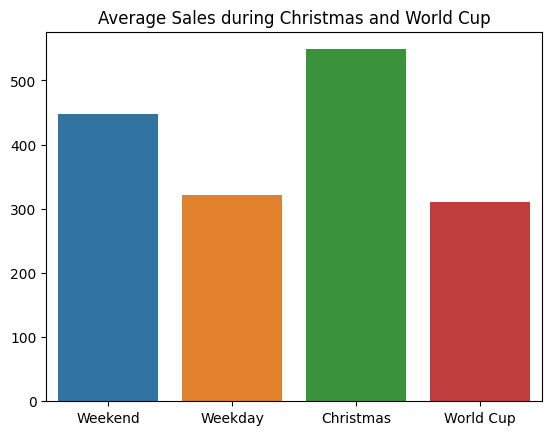

In [29]:
# Investigate the relationship of the World Cup and Christmas with sales
events_df = pd.DataFrame({'weekend': df.query('dayofweek in [5, 6]').sales.mean(),
                            'weekday': df.query('dayofweek not in [5, 6]').sales.mean(),
                            'christmas': df.query('description.str.contains("Navidad")').sales.mean(),
                            'worldcup': df.query('description.str.contains("Mundial de futbol")').sales.mean()},
                            index=['sales'])

sns.barplot(events_df)
plt.gca().set_xticklabels(['Weekend', 'Weekday', 'Christmas', 'World Cup'])
plt.title('Average Sales during Christmas and World Cup');

* Sales were significantly higher during the Christmas period, which helps explain the higher sales in December. 
* As expected, the World Cup had no effect on sales.

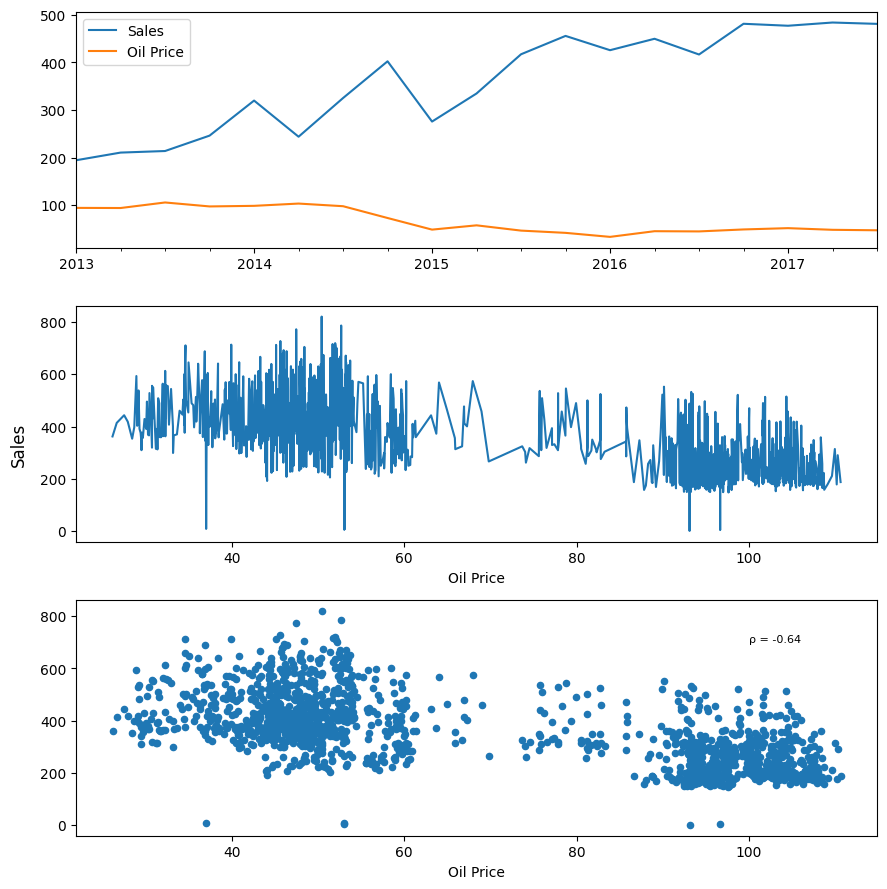

In [30]:
# Investigate the relationship between oil prices and sales
fig, ax = plt.subplots(3, figsize=(9, 9))
df.groupby(pd.Grouper(key='date', freq='BQ'))[['sales', 'dcoilwtico']].mean().to_period('Q').plot(ax=ax[0], xlabel='')
ax[0].legend(['Sales', 'Oil Price'])
df.groupby('dcoilwtico').sales.mean().plot(ax=ax[1], xlabel='Oil Price')
df.groupby('dcoilwtico').sales.mean().reset_index().plot.scatter(x='dcoilwtico', y='sales', ax=ax[2], xlabel='Oil Price', ylabel='')
plt.text(100, 700, f"ρ = {df.groupby('dcoilwtico').sales.mean().to_frame().reset_index().corr().iloc[0, 1]:.2f}", {'fontsize': 8})
fig.supylabel('Sales')
plt.tight_layout()

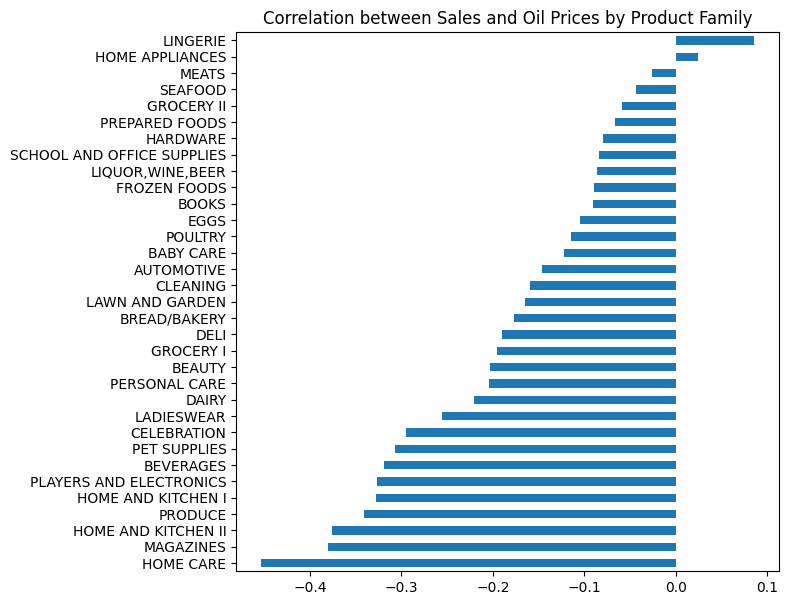

In [31]:
df.groupby('family')[['sales','dcoilwtico']].corr().loc[::2, 'dcoilwtico'].unstack().sort_values('sales').plot.barh(figsize=(7, 7), ylabel='', title='Correlation between Sales and Oil Prices by Product Family', legend=False);

* Overall, sales and oil prices shared a moderate inverse relationship. 
* The impact of oil prices on sales varied quite a bit from product family to product family.

### **Summary of Data Exploration**
1. Overall sales increased year-over-year.
2. The sales of most product families increased over the years.
3. Book product family was the latest launch: in 2016Q4.
4. Sales saw an uplift the week after public wages were paid out on the 15th and end of every month.
5. Weekend sales were significantly greater than weekday sales of which Thursday was the worst.
6. Sales increased slightly across the year, with Dec experiencing significantly higher sales because of Christmas.
7. Holiday sales were significantly higher than regular or even event days.
8. The 2016 earthquake elevated sales rather significantly.
9. Generally as oil prices rose, sales dipped.


### **Feature Engineering**

In [32]:
df = pd.read_parquet('dfp')
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,h_e_type,description,dcoilwtico,dayofweek,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075,1,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075,1,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075,1,1
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075,1,1
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,Primer dia del ano,93.1075,1,1


In [33]:
# Add calendar features
df['year'] = df.date.dt.year
df['dayofyear'] = df.date.dt.dayofyear
df['quarter'] = df.date.dt.quarter
df['week'] = df.date.dt.isocalendar().week

# Add weekend feature where 1 = a weekend, 0 = weekday
df['weekend'] = df.dayofweek.apply(lambda x: 1 if x == 6 or x == 7 else 0)

# Add wageweek feature
df['wageweek'] = df.date.isin(combined_filter).apply(lambda x: 1 if x==True else 0) # combined_filter defined earlier in data exploration phase

In [34]:
# Excluding national holidays, drop the dates of stores that had 0 total sales in 3 high volume categories (GROCERY I, PERSONAL CARE, BEVERAGES). If total sales = 0, then the store was likely to be closed on that day
df = df.query('~(date not in @holidays_events.date and family in ["GROCERY I", "PERSONAL CARE", "BEVERAGES"] and sales == 0)')

In [35]:
# Create a 5-day moving mean sales feature
df['rolling_5_mean_sales'] = 0

for family in df.family.unique():
    for i in range(1, 55):
        rolling_sales = df.query('sales > 0 and family == @family and store_nbr == @i').sales.rolling(5).mean()
        rolling_sales_indices = rolling_sales.index
        df.loc[rolling_sales_indices, 'rolling_5_mean_sales'] = rolling_sales

del rolling_sales, rolling_sales_indices
df = df.dropna()

In [36]:
# Drop these features
df = df.drop(columns=['h_e_type', 'dcoilwtico'])

# Reduce memory usage
df = df.astype({'dayofweek': 'int8',
                'year': 'int16',
                'month': 'int8',
                'dayofyear': 'int16',
                'quarter': 'int8',
                'week': 'int8',
                'weekend': 'int8',
                'wageweek': 'int8',    
                })

In [37]:
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,description,dayofweek,month,year,dayofyear,quarter,week,weekend,wageweek,rolling_5_mean_sales
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Primer dia del ano,1,1,2013,1,1,1,0,0,0.0
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Primer dia del ano,1,1,2013,1,1,1,0,0,0.0
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Primer dia del ano,1,1,2013,1,1,1,0,0,0.0
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Primer dia del ano,1,1,2013,1,1,1,0,0,0.0
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Primer dia del ano,1,1,2013,1,1,1,0,0,0.0


### **Model Training (Global Approach)** 

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool

In [40]:
X = df.drop(columns=['sales'])
y = df[['date', 'sales']]

X_train = X.query('date <= "2016-11-15"')
X_test = X.query('date > "2016-11-15"')

y_train = y.query('date <= "2016-11-15"').drop(columns='date')
y_test = y.query('date > "2016-11-15"').drop(columns='date')

cat_features = ['family', 'city', 'state', 'type', 'description']
train_pool = Pool(X_train, y_train, cat_features)
test_pool = Pool(X_test, y_test, cat_features)

In [41]:
cbr = CatBoostRegressor(iterations=2000, 
                        learning_rate = 0.1,
                        depth=10,
                        random_seed=4, 
                        one_hot_max_size=65,
                        verbose=50,
                        task_type='GPU')
cbr.fit(train_pool, eval_set=test_pool, early_stopping_rounds=200)

0:	learn: 947.0891917	test: 1261.8501865	best: 1261.8501865 (0)	total: 32.8ms	remaining: 1m 5s
50:	learn: 224.8141852	test: 298.4102120	best: 298.4102120 (50)	total: 1.72s	remaining: 1m 5s
100:	learn: 202.3820315	test: 290.7878970	best: 290.6041561 (98)	total: 3.47s	remaining: 1m 5s
150:	learn: 189.5824123	test: 284.9937702	best: 284.9937702 (150)	total: 5.24s	remaining: 1m 4s
200:	learn: 180.1563080	test: 280.2316378	best: 280.2316378 (200)	total: 6.99s	remaining: 1m 2s
250:	learn: 172.0376413	test: 277.2163134	best: 277.2163134 (250)	total: 8.8s	remaining: 1m 1s
300:	learn: 165.9992104	test: 275.1299017	best: 275.0358862 (296)	total: 10.5s	remaining: 59.5s
350:	learn: 160.8669552	test: 274.5461503	best: 274.5461503 (350)	total: 12.3s	remaining: 57.9s
400:	learn: 155.4065414	test: 270.5707533	best: 270.5707533 (400)	total: 14.1s	remaining: 56.3s
450:	learn: 151.1267980	test: 269.1024870	best: 269.1009930 (448)	total: 15.9s	remaining: 54.5s
500:	learn: 147.4490592	test: 269.7466459	bes

In [42]:
cbr_preds = cbr.predict(X_test)
cbr_preds[cbr_preds < 0] = 0

print(f'Root mean squared error of model: {mean_squared_error(y_test, cbr_preds, squared=False):.2f}')

Root mean squared error of model: 268.76


### **Model Evaluation**

In [43]:
# I will evaluate the model's performance by product family using the metrics: mean absolute error and mean absolute percentage error

global_preds = {} # A dictionary that can be easily used to visualise predictions against actual values
global_MAE = []
global_MAPE = []
y_test.insert(0, 'date', X_test.date) # Add date column back

# Create a mean absolute percentage error function that handles infinity values
def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    ape[np.isinf(ape)] = 0.0
    return np.mean(ape) * 100

for family in df.family.unique():
    preds = cbr.predict(X_test.query('family == @family'))
    preds[preds < 0] = 0
    actual = y_test.loc[X_test.query('family == @family').index]
    global_preds[family] = actual.assign(preds = preds).rename(columns={'sales': 'actual'}).to_dict()

    global_MAE.append(mean_absolute_error(actual.sales, preds))
    global_MAPE.append(mape(actual.sales, preds))

    del preds, actual

In [44]:
metrics_df = pd.DataFrame({'global_MAE': global_MAE, 'global_MAPE': global_MAPE}, df.family.unique())
metrics_df.sort_values('global_MAPE', ascending=False)

,global_MAE,global_MAPE
HARDWARE,3.859853,189.782891
MAGAZINES,5.509888,136.114263
HOME APPLIANCES,3.567107,135.952745
BEAUTY,5.626499,134.636571
LINGERIE,5.874439,128.116281
SCHOOL AND OFFICE SUPPLIES,5.995267,122.544551
PET SUPPLIES,6.241455,122.385592
AUTOMOTIVE,6.212009,121.295599
CELEBRATION,8.821283,103.899173
PLAYERS AND ELECTRONICS,7.131632,95.736778


* The model's performance is terrible when it comes to predicting product families with a low volume of sales, but decent when it comes to families with a high volume of sales.
* A plausible explanation is that the low sales volume product families such as HARDWARE and HOME APPLIANCES have more variance than high sales volume families such as PRODUCE and GROCERY I.

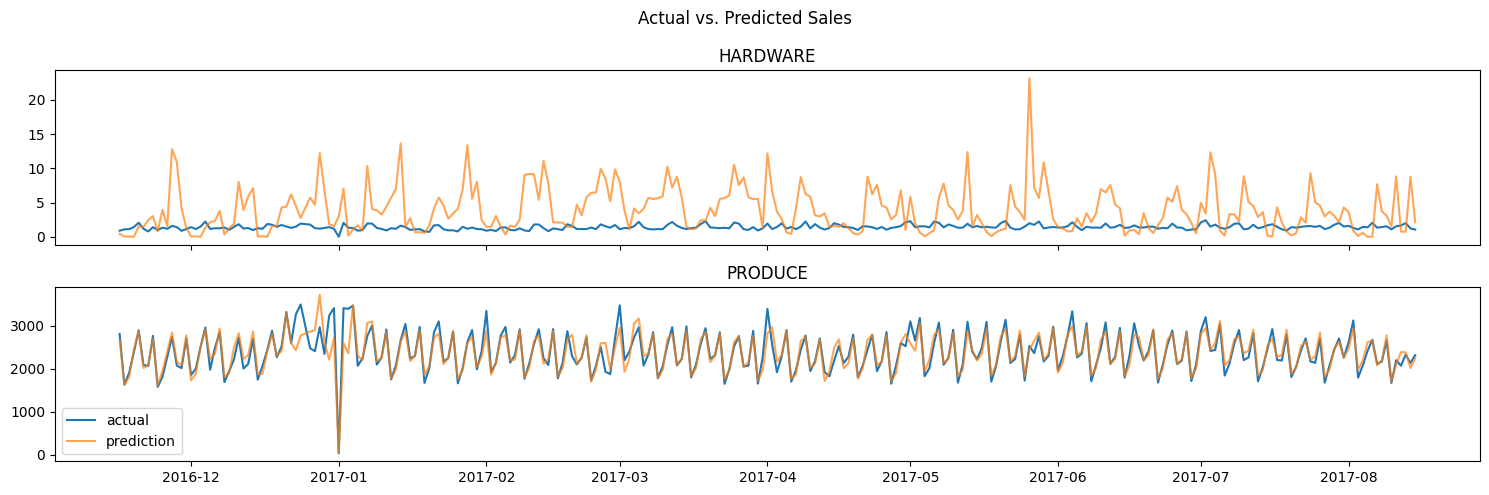

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
ax[0].plot(pd.DataFrame(global_preds['HARDWARE']).groupby('date').mean().actual)
ax[0].plot(pd.DataFrame(global_preds['HARDWARE']).groupby('date').mean().preds, alpha=0.7)
ax[0].set_title('HARDWARE')

ax[1].plot(pd.DataFrame(global_preds['PRODUCE']).groupby('date').mean().actual)
ax[1].plot(pd.DataFrame(global_preds['PRODUCE']).groupby('date').mean().preds, alpha=0.7)
ax[1].set_title('PRODUCE')

plt.suptitle('Actual vs. Predicted Sales')
plt.legend(['actual', 'prediction'])
plt.tight_layout();

#### **Logging the target variable**

In [46]:
# Log target variable to reduce its variance 
y_train_logged = np.log(y_train[['sales']] + 1)
y_test_logged = np.log(y_test[['sales']] + 1)

train_pool_logged = Pool(X_train, y_train_logged, cat_features)
test_pool_logged = Pool(X_test, y_test_logged, cat_features)

In [47]:
cbr_logged = CatBoostRegressor(iterations=2000, 
                        learning_rate = 0.1,
                        depth=10,
                        random_seed=4, 
                        one_hot_max_size=65,
                        verbose=50,
                        task_type='GPU')
cbr_logged.fit(train_pool_logged, eval_set=test_pool_logged, early_stopping_rounds=200)

0:	learn: 2.4379071	test: 2.4115358	best: 2.4115358 (0)	total: 53.2ms	remaining: 1m 46s
50:	learn: 0.2836386	test: 0.3157533	best: 0.3157533 (50)	total: 1.76s	remaining: 1m 7s
100:	learn: 0.2719937	test: 0.3082036	best: 0.3082036 (100)	total: 3.48s	remaining: 1m 5s
150:	learn: 0.2661103	test: 0.3061672	best: 0.3061672 (150)	total: 5.24s	remaining: 1m 4s
200:	learn: 0.2625711	test: 0.3040513	best: 0.3040513 (200)	total: 7s	remaining: 1m 2s
250:	learn: 0.2598071	test: 0.3027946	best: 0.3027946 (250)	total: 8.77s	remaining: 1m 1s
300:	learn: 0.2573547	test: 0.3018428	best: 0.3018428 (300)	total: 10.5s	remaining: 59.2s
350:	learn: 0.2558266	test: 0.3011711	best: 0.3011355 (349)	total: 12.2s	remaining: 57.5s
400:	learn: 0.2542543	test: 0.3003959	best: 0.3003959 (400)	total: 14s	remaining: 56s
450:	learn: 0.2530487	test: 0.3000648	best: 0.2999990 (438)	total: 15.9s	remaining: 54.5s
500:	learn: 0.2519223	test: 0.2994224	best: 0.2994224 (500)	total: 17.6s	remaining: 52.7s
550:	learn: 0.2509964

In [48]:
global_preds_logged = {}
global_MAE_logged = []
global_MAPE_logged = []
y_test_logged.insert(0, 'date', X_test.date)

for family in df.family.unique():
    preds = np.exp(cbr_logged.predict(X_test.query('family == @family'))) - 1
    preds[preds < 0] = 0
    actual = y_test_logged.loc[X_test.query('family == @family').index]
    global_preds_logged[family] = actual.assign(preds = preds).rename(columns={'sales': 'actual'}).to_dict()

    global_MAE_logged.append(mean_absolute_error(np.exp(actual.sales)-1, preds))
    global_MAPE_logged.append(mape(np.exp(actual.sales)-1, preds))

    del preds, actual

In [49]:
logged_metrics_df = pd.DataFrame({'global_MAE_logged': global_MAE_logged, 'global_MAPE_logged': global_MAPE_logged}, df.family.unique())
logged_metrics_df.sort_values('global_MAPE_logged', ascending=False)

,global_MAE_logged,global_MAPE_logged
LINGERIE,2.637272,51.818355
"LIQUOR,WINE,BEER",31.999478,47.410484
CELEBRATION,4.742512,47.403925
AUTOMOTIVE,2.434819,45.710120
GROCERY II,7.486739,44.280465
HOME AND KITCHEN I,11.911594,43.714331
LAWN AND GARDEN,5.438969,42.999500
BEAUTY,1.662657,41.933108
PLAYERS AND ELECTRONICS,3.182996,39.092302
MAGAZINES,1.924010,38.819863


* Results of the logged target version look promising. Half of the MAPE are well over 20%; however, with the exception of LIQUOR,WINE,BEER, the MAE of the product families in question are all very low. Stocking a few more pieces of lingerie or products for celebration is not the end of the world for a supermarket.

In [50]:
def highlight(df):
    return ['background-color: #FF6F6F' if x > 0 else 'background-color: default' for x in df]  

# Get the difference between the original evaluation and the new one
(logged_metrics_df - metrics_df.values).sort_values('global_MAPE_logged').style.apply(highlight)

,global_MAE_logged,global_MAPE_logged
HARDWARE,-3.279833,-156.021918
HOME APPLIANCES,-3.385107,-120.208258
MAGAZINES,-3.585878,-97.294400
BEAUTY,-3.963842,-92.703463
SCHOOL AND OFFICE SUPPLIES,-3.387933,-86.186702
PET SUPPLIES,-3.969790,-85.217269
LINGERIE,-3.237166,-76.297926
AUTOMOTIVE,-3.777190,-75.585479
BABY CARE,-3.406040,-62.694553
BOOKS,-3.450985,-62.516325


* Negative values in the dataframe represent an improvement.
* Training the model on the logged version of the target resulted in significant improvements in performance. Only the MAEs of PRODUCE and GROCERY I worsened slightly.

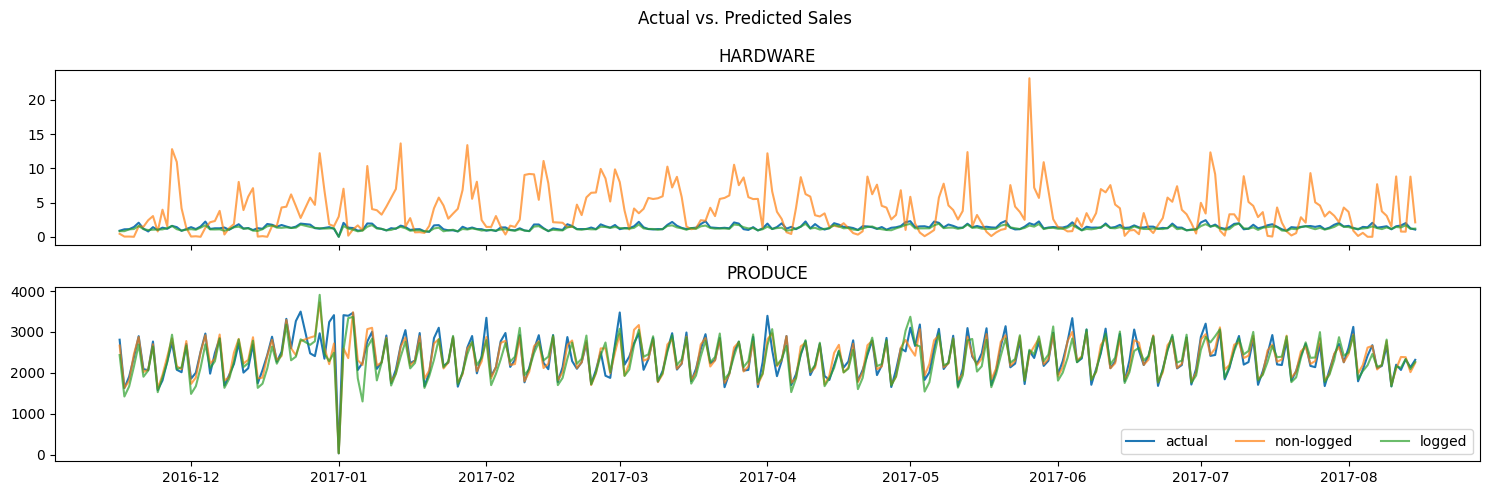

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
ax[0].plot(pd.DataFrame(global_preds['HARDWARE']).groupby('date').mean().actual)
ax[0].plot(pd.DataFrame(global_preds['HARDWARE']).groupby('date').mean().preds, alpha=0.7)
ax[0].plot(pd.DataFrame(global_preds_logged['HARDWARE']).groupby('date').mean().preds, alpha=0.7)
ax[0].set_title('HARDWARE')

ax[1].plot(pd.DataFrame(global_preds['PRODUCE']).groupby('date').mean().actual)
ax[1].plot(pd.DataFrame(global_preds['PRODUCE']).groupby('date').mean().preds, alpha=0.7)
ax[1].plot(pd.DataFrame(global_preds_logged['PRODUCE']).groupby('date').mean().preds, alpha=0.7)
ax[1].set_title('PRODUCE')

plt.suptitle('Actual vs. Predicted Sales')
plt.legend(['actual', 'non-logged', 'logged'], loc='lower right', ncol=3)
plt.tight_layout();

### **Concluding Thoughts**
* Although the predictions of the model are decent, other models or approaches like a local one where a separate model is trained on each specific product family might produce better results.
* Model could be tuned to potentially improve performance. 